# Dataset description



*   Cement (cement) -- quantitative -- kg in a m3 mixture -- Input Variable
*   Blast Furnace Slag (slag) -- quantitative -- kg in a m3 mixture -- Input Variable
*   Fly Ash (ash) -- quantitative -- kg in a m3 mixture -- Input Variable
*   Water (water) -- quantitative -- kg in a m3 mixture -- Input Variable
*   Superplasticizer (superplastic) -- quantitative -- kg in a m3 mixture -- Input Variable
*   Coarse Aggregate (coarseagg) -- quantitative -- kg in a m3 mixture -- Input Variable
*   Fine Aggregate (fineagg) -- quantitative -- kg in a m3 mixture -- Input Variable
*   Age(age) -- quantitative -- Day (1~365) -- Input Variable
*   Concrete compressive strength(strength) -- quantitative -- MPa -- Output Variable









# Steps:
1. Import the libs
2. First look at the data
3. Exploratory data analysis <br />
    3.1. IQR and ouliers analysis (box plot)<br />
    3.2. Distribution of independent variables <br />
    3.3. Pair plots <br />
    3.4. Heat map analysis <br />
4. K-Means clustering - deal with multiple gaussians
5. Model building - Iteration 1 --> Use data as is
6. Model building - Iteration 2 --> Include the results of outlier treatment
7. Model building - Iteration 3 --> Include the results of K-means clustering
8. Model building - Iteration 4 --> Normalize/Standardize the data before model building
9. Hyper parameter training on best model from all iterations

# Import the libs

In [1]:
# Import the numerical algebra libs
import pandas as pd
import numpy as np

# Import visualization libs
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# First look at the data

In [3]:
#BASE_PATH = "/content/drive/My Drive/Colab Notebooks/datasets/"
BASE_PATH = ""
file_name = "concrete_strength_predication.csv"

In [4]:
data = pd.read_csv(BASE_PATH + file_name)
print(f"The given dataset contains {data.shape[0]} rows and {data.shape[1]} columns")
print(f"The given dataset contains {data.isna().sum().sum()} Null value")

The given dataset contains 1030 rows and 9 columns
The given dataset contains 0 Null value


In [5]:
data.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


### Observations

1.   All of the data in the dataset is numerical
2.   No null/NAN data
3.   Age data appears to have outliers because max value is very large as compared to 3rd IQR value

# Exploratory data analysis

## Box plots

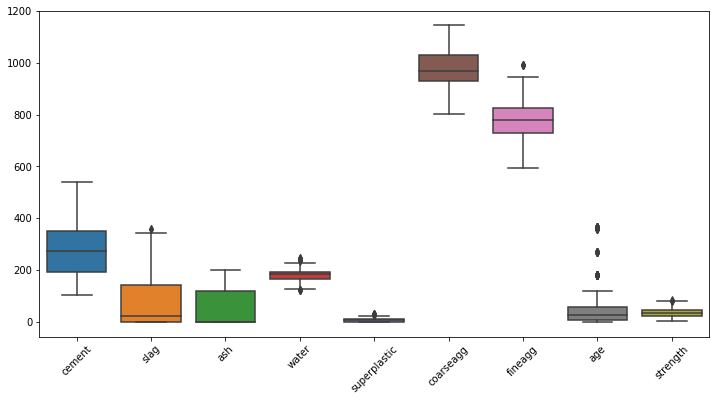

In [8]:
plt.subplots(figsize=(12, 6))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

### Observations

* Age column appears to be having maximum number of outliers
* Slag, Water, superplastic, fineagg features have some outliers
* All features except age and strength have same units(kg in m3 mixture) but have different scales. Thus we might need to scale the data so as to avoid bias in algorithms

## Distribution of independent variables


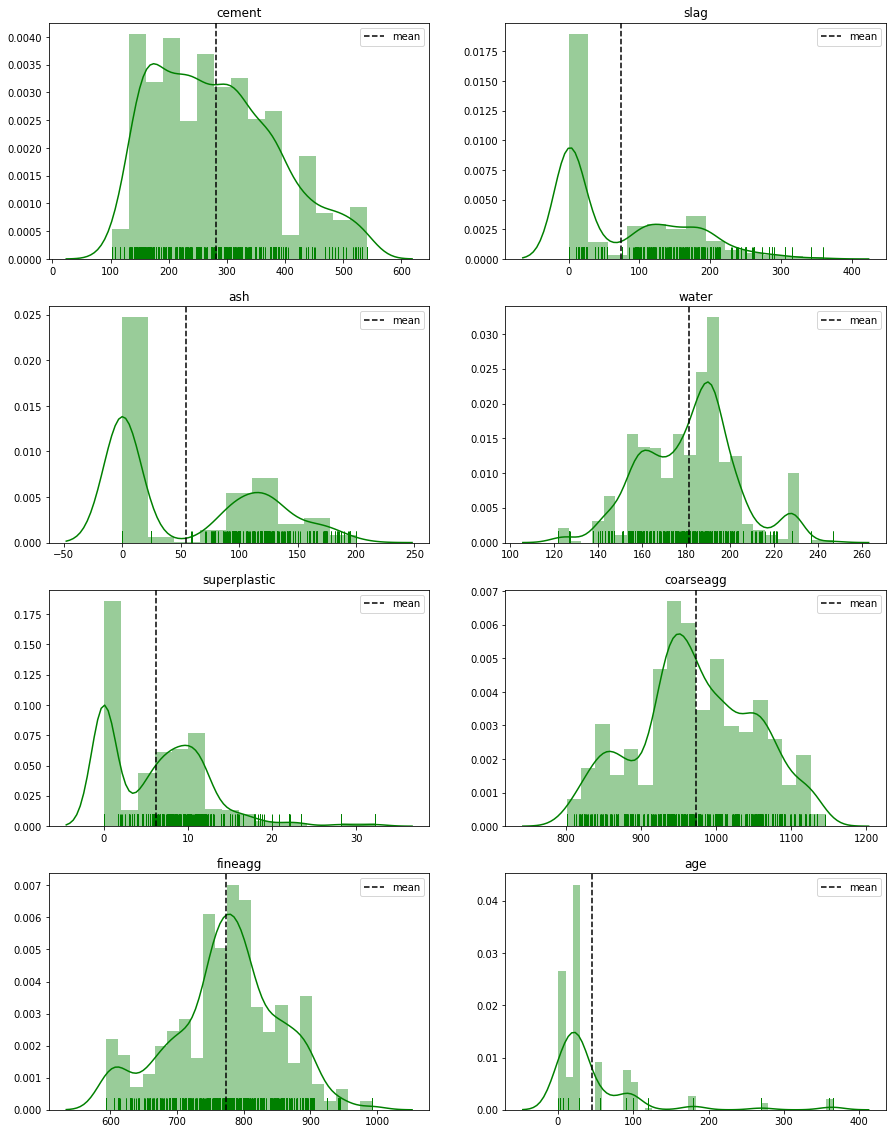

In [9]:
import itertools

cols = [i for i in data.columns if i != 'strength']

fig = plt.figure(figsize=(15, 20))

for i,j in itertools.zip_longest(cols, range(len(cols))):
    plt.subplot(4,2,j+1)
    ax = sns.distplot(data[i],color='green',rug=True)
    plt.axvline(data[i].mean(),linestyle="dashed",label="mean", color='black')
    plt.legend()
    plt.title(i)
    plt.xlabel("")

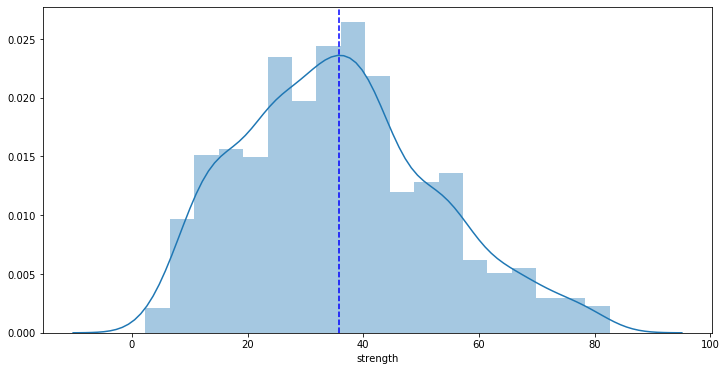

In [10]:
fig = plt.figure(figsize=(12, 6))
plt.axvline(data.strength.mean(),linestyle="dashed",label="mean", color='blue')
sns.distplot(data.strength);

## Pair plot

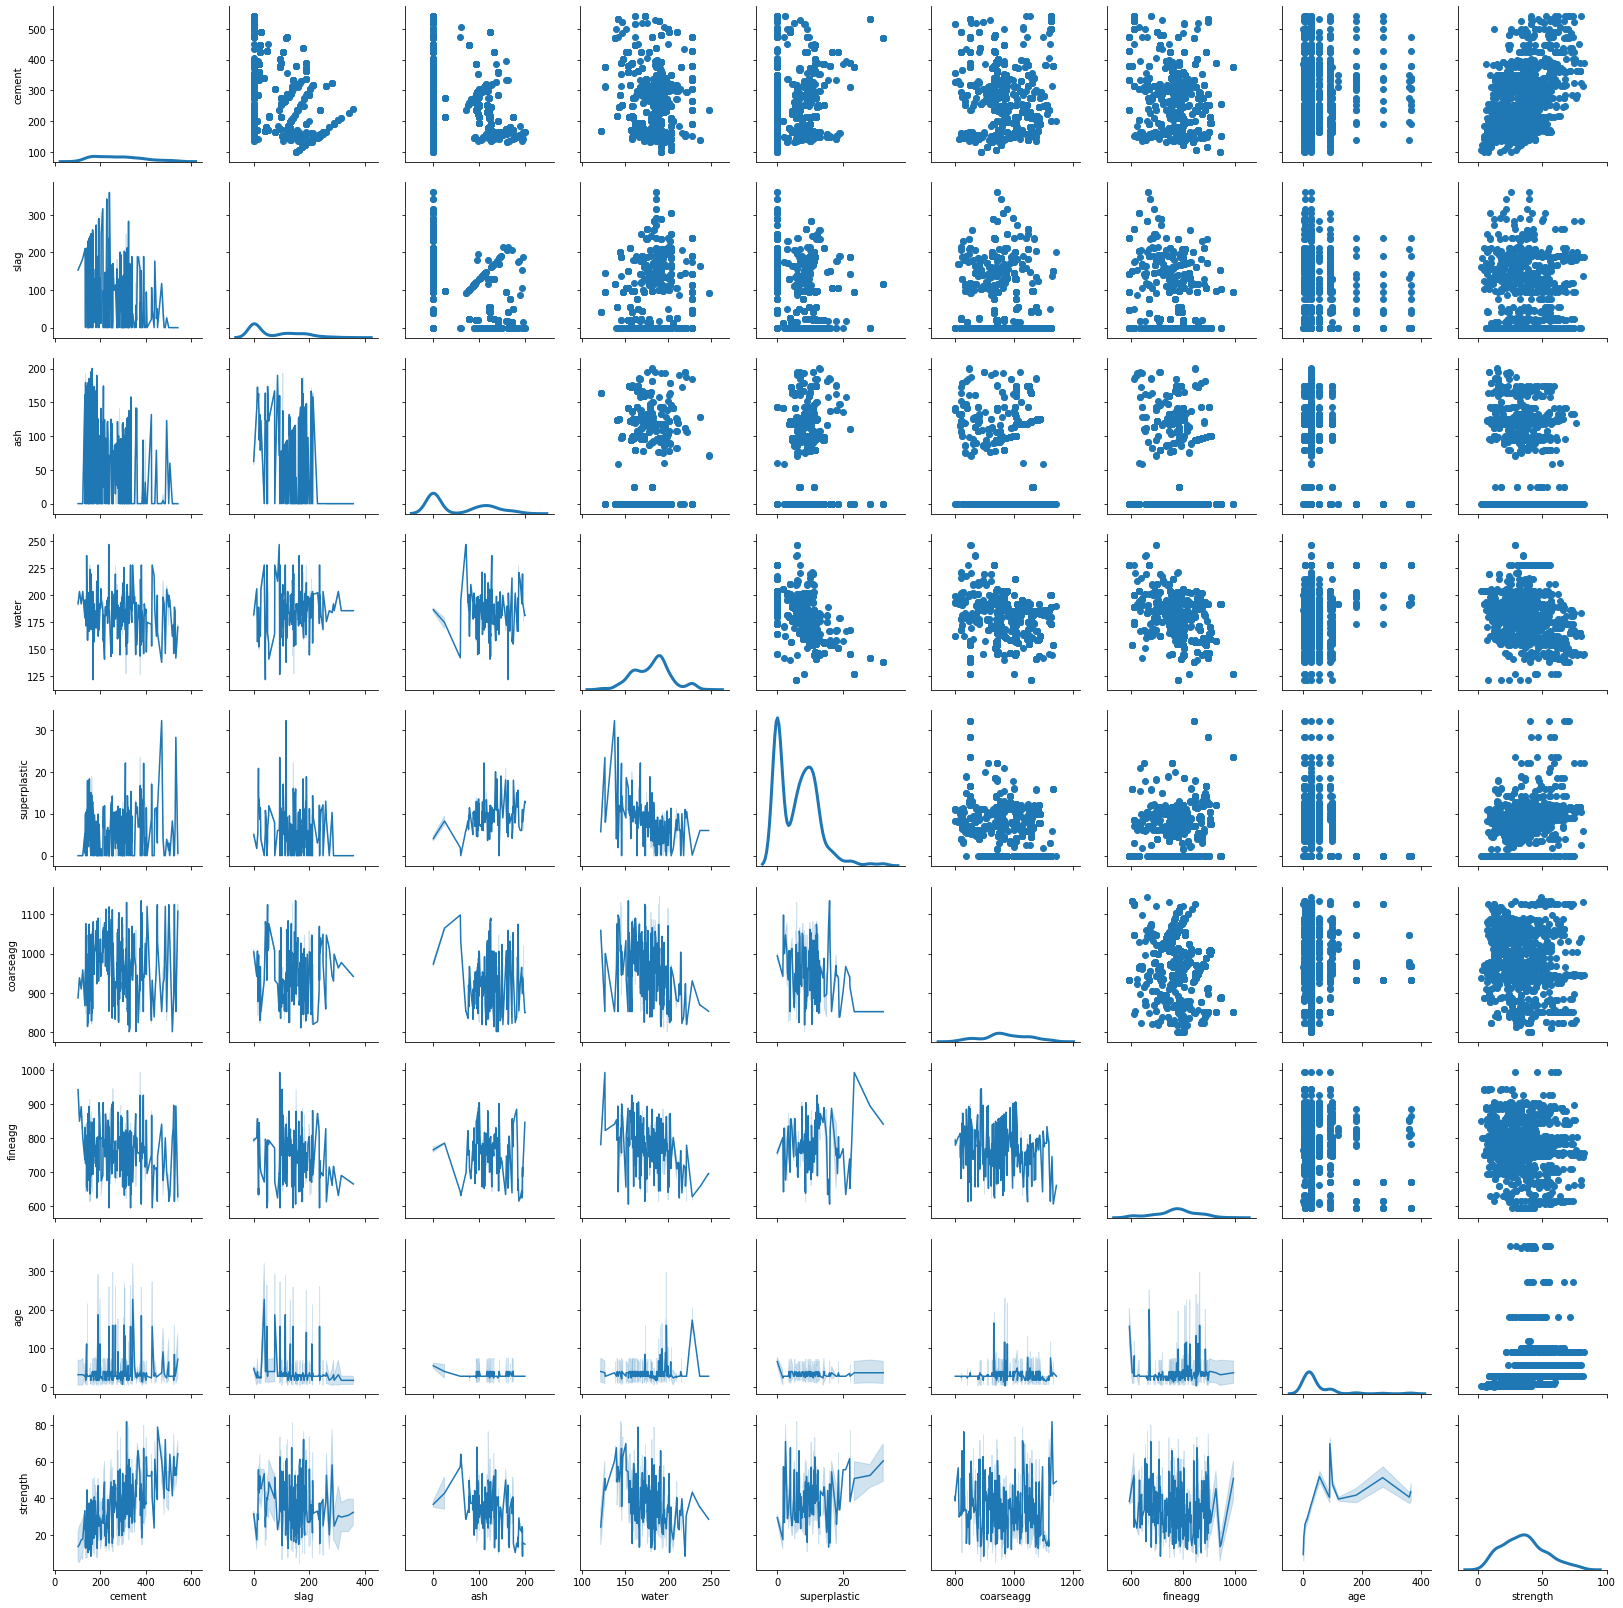

In [11]:
# Build a pair plot

g = sns.PairGrid(data)
g.map_upper(plt.scatter)
g.map_lower(sns.lineplot)
g.map_diag(sns.kdeplot, lw=3, legend=True);

### Observations

#### Diagonal analysis + dist plots analysis
* Distribution of cement appears nearly normal
* Slag and ash has 2 gaussians and is skewed
* Water and Superplastic have near normal distributions
* Age data has long tail which confirms the presence of outliers
* Strength is normally distributed

#### Off-diagonal analysis with strength
* Cement has strong correlation with strength
* Slag is a very weak predictor because the distribution is like a cloud
* ash, coarseagg and fineagg are also weak predictors
* Water appears to have a negative correlation with strength
* Superplastic appears to have positive correlation with strength
* age also has strong correlation with strength

#### Off-diagonal analysis between other features
* Cement and slag have strong correlation
* Water and super plastic have strong negative correlation

## Heat map

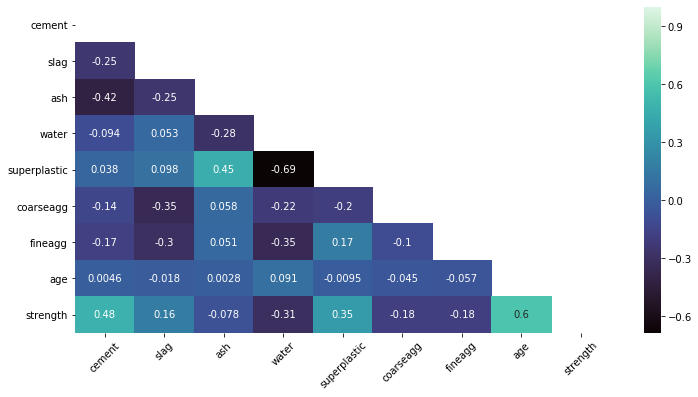

In [12]:
plt.subplots(figsize=(12, 6))
corr = data.corr('spearman')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(data=corr, cmap='mako', annot=True, mask=mask)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

### Observations

* As expected, cement and age have strong correlation with strength
* Super plastic has mild positive correlation with strength
* As expected, water and superplastic have strong correlation

## 3D graph between 3 most important features and target

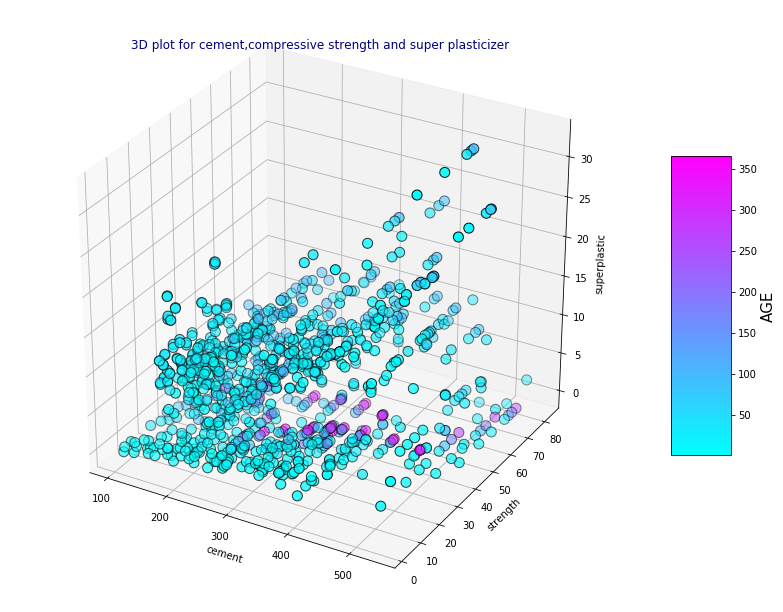

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,11))

ax  = fig.gca(projection = "3d")
#plt.subplot(111,projection = "3d") 

plot =  ax.scatter(data["cement"],
           data["strength"],
           data["superplastic"],
           linewidth=1,edgecolor ="k",
           c=data["age"],s=100,cmap="cool")

ax.set_xlabel("cement")
ax.set_ylabel("strength")
ax.set_zlabel("superplastic")

lab = fig.colorbar(plot,shrink=.5,aspect=5)
lab.set_label("AGE",fontsize = 15)

plt.title("3D plot for cement,compressive strength and super plasticizer",color="navy")
plt.show()

# K-Means clustering

Ash, Superplastic, slag appear to have 2 gaussian

In [14]:
from sklearn.cluster import KMeans

# Create a copy of the data
data_copy = data.copy(deep=True)
tmp_df = data_copy[['ash', 'superplastic', 'slag']]

cluster_range = range( 2, 15 ) 
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(tmp_df)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:15]

,num_clusters,cluster_errors
0,2,5.168372e+06
1,3,2.869576e+06
2,4,1.758353e+06
3,5,1.037805e+06
4,6,8.036260e+05
5,7,6.034191e+05
6,8,4.926951e+05
7,9,4.205389e+05
8,10,3.627460e+05
9,11,3.057430e+05


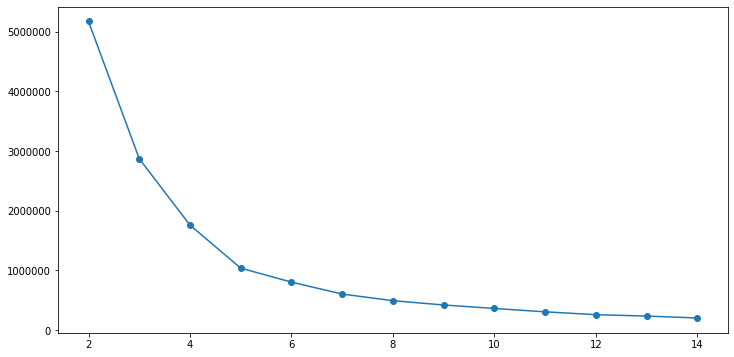

In [15]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" );

In [16]:
from sklearn.cluster import KMeans
from scipy.stats import zscore

tmp_df_z = tmp_df.apply(zscore)

cluster = KMeans( n_clusters = 5, random_state = 2354 )
cluster.fit(tmp_df_z)

prediction=cluster.predict(tmp_df_z)
data_copy["group"] = prediction 

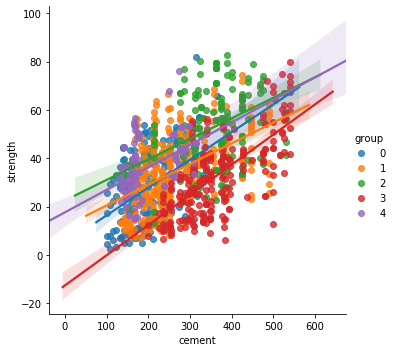

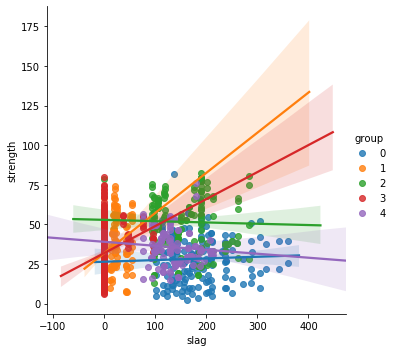

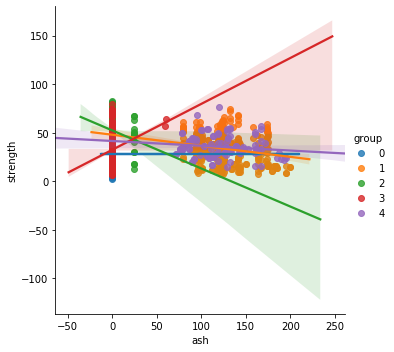

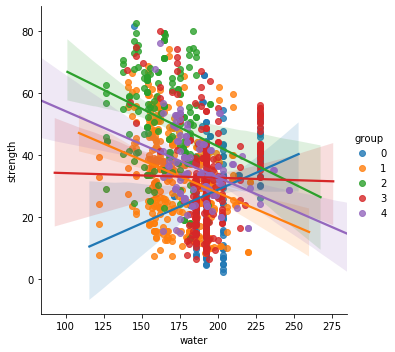

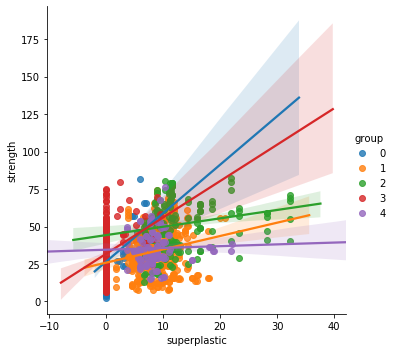

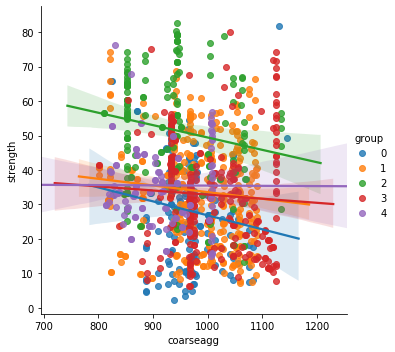

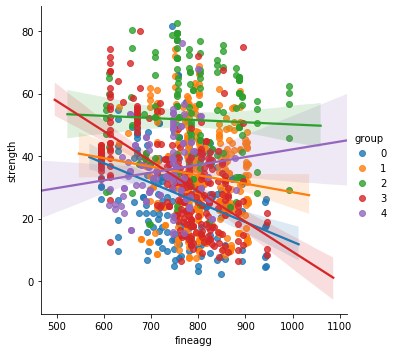

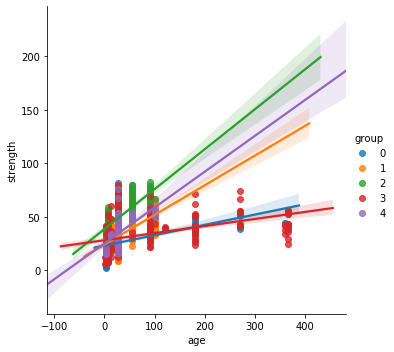

In [17]:
for col in data_copy.columns[:-2]:
  sns.lmplot(data=data_copy, x=col, y='strength', hue='group')

### Observations

From the above analysis, it can be seen
1. Water, superplastic, age and cement are the most important attributes for strength prediction
2. ash, coarseagg and fineagg are not strong predictors. Thus we can try removing them
3. slag is mildly important predictor

# Model building

 We will try the following algorithms:
1. Linear Regression
2. Linear Regression with Polynomial features of degree 2
3. Linear Regression with Polynomial features of degree 3
4. Ridge 
5. Ridge with polynomial features of degree 2
6. Ridge with polynomial features of degree 3
7. Lasso 
8. Lasso with polynomial features of degree 2
9. Lasso with polynomial features of degree 3
10. Decision Trees
11. Random forest
12. Ada boosting
13. Gradient boosting
14. KNN
15. Support Vector machines

We will always scale the data as confirmed in EDA

we will perform the analysis in following iterations
1. Build the models and perform analysis on all data
2. Treat outliers and build models again
3. Consider the results of Feature engineering (k-means clustering)
4. Discuss and compare all the results

In [18]:
# Helper classes
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np

class Regressor(object):
    """
    Class representing a regressor. 
    Based on the parameters supplied in the constructor, this class constructs a pipeline object.
    The constructed pipeline adds 
    - Standard scalar if the scale parameter is passed as True
    - Polynomial Feature transformations if the include_polymomial flag is set as True
    """
    def __init__(self, name, model, scale=True, include_polynomial=False, degree=2):
        self.name = name
        self.model = model
        steps = []
        if scale:
            steps.append(('scaler', StandardScaler()))
        if include_polynomial:
            steps.append(('poly_features', PolynomialFeatures(degree=degree)))
        steps.append(('model', model))
        self.steps = steps

    def get_name(self):
        return self.name

    def get_model(self):
        return self.model

    def get(self):
        return Pipeline(steps=self.steps)

    def feature_imp(self):
        try:
            return self.model.feature_importances_
        except AttributeError:
            try:
                return self.model.coef_
            except AttributeError:
                return None


class ModelsBuilder(object):
    '''
    This class is responsible for building the model and constructing a results dataframe.
    It accepts several regressor objects.
    '''
    def __init__(self, regressors, data, target, test_size=0.3, seed=42):
        self.regressors = regressors
        self.split_data = train_test_split(data.drop(target, axis=1), data[target], test_size=test_size, random_state=seed)
        self.data = data
        self.target = target

    def build(self, k_fold_splits=10):
        results = pd.DataFrame(columns=['model', 'training_score', 'test_score', 'k_fold_mean', 'k_fold_std'])
        for regressor in self.regressors:
            regressor.get().fit(self.split_data[0], self.split_data[2])
            cross_vals = cross_val_score(regressor.get(), self.data.drop(self.target, axis=1), self.data[self.target], cv=KFold(n_splits=k_fold_splits))
            mean = round(cross_vals.mean(), 3)
            std = round(cross_vals.std(), 3)
            results = results.append({
                'model': regressor.get_name(),
                'training_score': round(regressor.get().score(self.split_data[0], self.split_data[2]), 3),
                'test_score': round(regressor.get().score(self.split_data[1], self.split_data[3]),3), 
                'k_fold_mean': mean, 
                'k_fold_std': std, 
                '95% confidence intervals': str(round(mean-(1.96*std),3)) + ' <-> ' + str(round(mean+(1.96*std),3))
                }, ignore_index=True)

        return results


class OutliersImputer(SimpleImputer):
    '''
    This class extends the functionality of SimpleImputer to handle outliers.
    '''
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        super().__init__(strategy=strategy)

    def fit(self, X, y=None):
        for i in X.columns:
            q1, q2, q3 = X[i].quantile([0.25,0.5,0.75])
            IQR = q3 - q1
            a = X[i] > q3 + 1.5*IQR
            b = X[i] < q1 - 1.5*IQR
            X[i] = np.where(a | b, np.NaN, X[i])  
        return super().fit(X, y)

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

regressors = [
    Regressor('Linear Regression', LinearRegression(), scale=True), 
    Regressor('Linear Regression degree 2', LinearRegression(), 
              scale=True, include_polynomial=True, degree=2),
    Regressor('Linear Regression degree 3', LinearRegression(), 
              scale=True, include_polynomial=True, degree=3), 
    Regressor('Ridge', Ridge(random_state=42), scale=True), 
    Regressor('Ridge degree 2', Ridge(random_state=42), 
              scale=True, include_polynomial=True, degree=2),
    Regressor('Ridge degree 3', Ridge(random_state=42), 
              scale=True, include_polynomial=True, degree=3),
    Regressor('Lasso', Lasso(random_state=42), scale=True), 
    Regressor('Lasso degree 2', Lasso(random_state=42), 
              scale=True, include_polynomial=True, degree=2),
    Regressor('Lasso degree 3', Lasso(random_state=42), 
              scale=True, include_polynomial=True, degree=3), 
    Regressor('Decision Tree', DecisionTreeRegressor(random_state=42, max_depth=4), scale=True),
    Regressor('Ada boosting', AdaBoostRegressor(random_state=42), scale=True),
    Regressor('Random forest', RandomForestRegressor(random_state=42, max_depth=4), scale=True),
    Regressor('Gradient boosting', GradientBoostingRegressor(random_state=42, max_depth=4), scale=True),
    Regressor('KNN', KNeighborsRegressor(n_neighbors=3), scale=True),
    Regressor('SVR', SVR(gamma='auto'), scale=True),
]

In [20]:
# Iteration 1 - Use all data
result = ModelsBuilder(regressors, data, 'strength').build()
tmp_best = result.sort_values(['k_fold_mean'], ascending=False).head(1)
tmp_best['model'] = 'Best Model = ' + tmp_best['model']
result = result.append(tmp_best, ignore_index=True)
result

,model,training_score,test_score,k_fold_mean,k_fold_std,95% confidence intervals
0,Linear Regression,0.627,0.585,0.592,0.073,0.449 <-> 0.735
1,Linear Regression degree 2,0.827,0.744,0.778,0.043,0.694 <-> 0.862
2,Linear Regression degree 3,0.935,0.786,0.850,0.047,0.758 <-> 0.942
3,Ridge,0.627,0.585,0.592,0.073,0.449 <-> 0.735
4,Ridge degree 2,0.827,0.741,0.777,0.044,0.691 <-> 0.863
5,Ridge degree 3,0.929,0.860,0.863,0.040,0.785 <-> 0.941
6,Lasso,0.579,0.546,0.548,0.056,0.438 <-> 0.658
7,Lasso degree 2,0.725,0.688,0.690,0.042,0.608 <-> 0.772
8,Lasso degree 3,0.741,0.670,0.694,0.043,0.61 <-> 0.778
9,Decision Tree,0.729,0.666,0.672,0.054,0.566 <-> 0.778


In [21]:
# Iteration 2 - Ouliers treatment

# Count outliers
q1= data.quantile(0.25)
q3= data.quantile(0.75)
IQR = q3-q1
outliers = pd.DataFrame(((data > (q3+1.5*IQR)) | (data < (q1-IQR*1.5))).sum(axis=0), columns=['No. of outliers'])
outliers['Percentage of outliers'] = round(outliers['No. of outliers']*100/len(data), 2)
outliers

,No. of outliers,Percentage of outliers
cement,0,0.00
slag,2,0.19
ash,0,0.00
water,9,0.87
superplastic,10,0.97
coarseagg,0,0.00
fineagg,5,0.49
age,59,5.73
strength,4,0.39


In [22]:
data[['age','superplastic']] = OutliersImputer().fit_transform(data[['age','superplastic']])

In [23]:
result_outliers_treatment = ModelsBuilder(regressors, data, 'strength').build()
tmp_best = result_outliers_treatment.sort_values(['k_fold_mean'], ascending=False).head(1)
tmp_best['model'] = 'Best Model = ' + tmp_best['model']
result_outliers_treatment = result_outliers_treatment.append(tmp_best, ignore_index=True)
result_outliers_treatment

,model,training_score,test_score,k_fold_mean,k_fold_std,95% confidence intervals
0,Linear Regression,0.725,0.706,0.706,0.032,0.643 <-> 0.769
1,Linear Regression degree 2,0.871,0.836,0.843,0.026,0.792 <-> 0.894
2,Linear Regression degree 3,0.947,0.829,0.878,0.036,0.807 <-> 0.949
3,Ridge,0.725,0.706,0.706,0.032,0.643 <-> 0.769
4,Ridge degree 2,0.870,0.836,0.843,0.026,0.792 <-> 0.894
5,Ridge degree 3,0.941,0.872,0.885,0.025,0.836 <-> 0.934
6,Lasso,0.696,0.686,0.679,0.032,0.616 <-> 0.742
7,Lasso degree 2,0.772,0.761,0.754,0.029,0.697 <-> 0.811
8,Lasso degree 3,0.794,0.752,0.763,0.028,0.708 <-> 0.818
9,Decision Tree,0.729,0.666,0.672,0.054,0.566 <-> 0.778


In [24]:
# Iteration 3 - Remove features based on k-means clustering
result_feature_engg = ModelsBuilder(regressors, data.drop(['ash', 'coarseagg', 'fineagg'], axis=1), 'strength').build()
tmp_best = result_feature_engg.sort_values(['k_fold_mean'], ascending=False).head(1)
tmp_best['model'] = 'Best Model = ' + tmp_best['model']
result_feature_engg = result_feature_engg.append(tmp_best, ignore_index=True)
result_feature_engg

,model,training_score,test_score,k_fold_mean,k_fold_std,95% confidence intervals
0,Linear Regression,0.712,0.689,0.692,0.040,0.614 <-> 0.77
1,Linear Regression degree 2,0.832,0.796,0.808,0.026,0.757 <-> 0.859
2,Linear Regression degree 3,0.885,0.847,0.850,0.032,0.787 <-> 0.913
3,Ridge,0.712,0.689,0.692,0.040,0.614 <-> 0.77
4,Ridge degree 2,0.832,0.796,0.809,0.026,0.758 <-> 0.86
5,Ridge degree 3,0.885,0.846,0.851,0.032,0.788 <-> 0.914
6,Lasso,0.694,0.682,0.675,0.033,0.61 <-> 0.74
7,Lasso degree 2,0.771,0.761,0.754,0.028,0.699 <-> 0.809
8,Lasso degree 3,0.783,0.750,0.758,0.032,0.695 <-> 0.821
9,Decision Tree,0.729,0.666,0.677,0.051,0.577 <-> 0.777


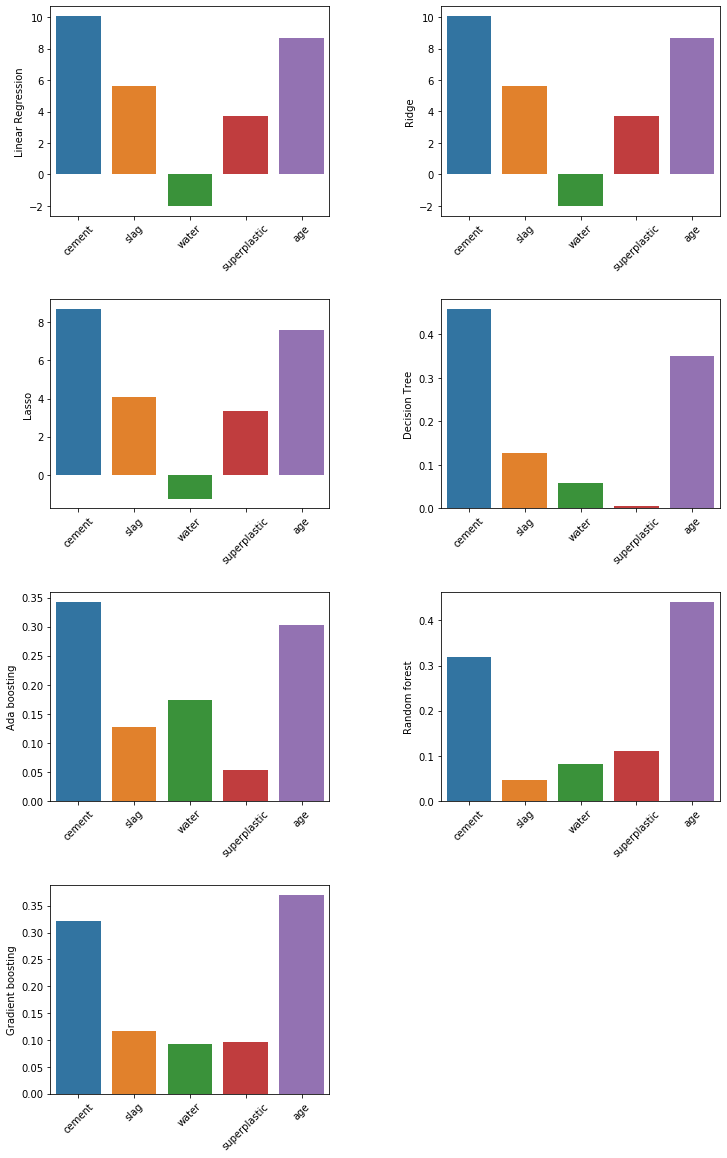

In [25]:
columns = data.drop(['ash', 'coarseagg', 'fineagg', 'strength'], axis=1).columns
feature_imp = pd.DataFrame(index=columns)
for r in regressors:
    fi = r.feature_imp()
    if fi is not None and len(fi) == len(columns):
        feature_imp[r.get_name()] = fi


plt.figure(figsize=(12, 20))
for i, col in enumerate(feature_imp.columns):
  plt.subplot(4, 2, i+1)
  ax = sns.barplot(x=feature_imp.index, y=feature_imp[col])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [26]:
feature_imp

,Linear Regression,Ridge,Lasso,Decision Tree,Ada boosting,Random forest,Gradient boosting
cement,10.083763,10.065692,8.708484,0.458275,0.342773,0.319532,0.322194
slag,5.618662,5.605275,4.107803,0.127801,0.127100,0.047483,0.117090
water,-2.009896,-2.010119,-1.246963,0.058036,0.174142,0.081397,0.093178
superplastic,3.693681,3.690151,3.332595,0.005039,0.053180,0.110538,0.096794
age,8.661148,8.647985,7.576861,0.350849,0.302805,0.441049,0.370745


### Observations

1. Outliers treatment improves the overall performace on most of the models
2. Removing the features (ash, coarseagg and fineagg) does not affect the models. 
3. Gradient boosting is clearly the best model. It provides better complexity with 95% confidence interval between 88% and 95%

# Hyper parameter tuning

<p> At this point we can conclude that Gradient boosting is perfect fit to predict the strength of concrete based on the given dataset. </p>
<p> Now we can tune the hyper parameters for gradient boosting </p>

#### Steps:
1. Split the data into training and testing set (80-20)
2. Use the training data to perform cross validation hyper parameter tuning using Grid Search
3. Check the best performing model against the test set

In [27]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['ash', 'coarseagg', 'fineagg', 'strength'], axis=1), 
                                                   data['strength'], 
                                                   test_size = 0.2, 
                                                   random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((824, 5), (206, 5), (824,), (206,))

In [28]:
# Prepare parameter grid
param_grid = {
    'criterion': ['mse', 'mae', 'friedman_mse'], 
    'learning_rate': [0.05, 0.1, 0.15, 0.2], 
    'max_depth': [2, 3, 4, 5], 
    'max_features': ['sqrt', None], 
    'max_leaf_nodes': list(range(2, 10)),
    'n_estimators': list(range(50, 500, 50)),
    'subsample': [0.8, 0.9, 1.0]
}

In [29]:
# Perform hyper parameter tuning using GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_distributions=param_grid, 
                 return_train_score= True, n_jobs=-1, verbose=2, cv = 10, n_iter=500)
rs.fit(X_train, y_train)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 998 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1506 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2086 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2696 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3401 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4234 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 10.0min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                           

In [30]:
mean = rs.best_score_
std = rs.cv_results_['mean_test_score'].std()

print(f"Mean training score: {rs.cv_results_['mean_train_score'].mean()}")
print(f"Mean validation score: {mean}")
print(f"Validation standard deviation: {std}")
print(f"95% confidence interval: {str(round(mean-(1.96*std),3)) + ' <-> ' + str(round(mean+(1.96*std),3))}")
print(f"Best parameters: {rs.best_params_}")
print(f"Test score: {rs.score(X_test, y_test)}")

Mean training score: 0.9263896965699349
Mean validation score: 0.9305797178196953
Validation standard deviation: 0.051898027465949355
95% confidence interval: 0.829 <-> 1.032
Best parameters: {'subsample': 0.8, 'n_estimators': 400, 'max_leaf_nodes': 8, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.1, 'criterion': 'mse'}
Test score: 0.9288023075941881


# Conclusion

In the above study, we find that in order to predict the strength of concrete
1. The features that affect the strength are cement, slag, water, superplastic and age
2. The best model is Gradient boosting
3. Using the above model, we can predict the strength accurately between 83% to 100% with 95% confidence. (While the prints above shows 95% confidence as 0.83 and 1.03. It it actually 0.831 to 1 since we cannot predict more than 100%)